**Objective**: In this lab, you will implement and compare manual grid search with scikit-learn's built-in GridSearchCV for hyperparameter tuning. You'll work with multiple classification algorithms and combine them using voting classifiers.

**Learning Goals**:
- Understand hyperparameter tuning through grid search
- Compare manual implementation with built-in functions
- Learn to create and evaluate voting classifiers
- Work with multiple real-world datasets
- Visualize model performance using ROC curves and confusion matrices

**Datasets Used**:
1. Wine Quality - Predicting wine quality based on chemical properties
2. HR Attrition - Predicting employee turnover
3. Banknote Authentication - Detecting counterfeit banknotes
4. QSAR Biodegradation - Predicting chemical biodegradability



## Part 1: Import Libraries and Setup

First, let's import all the necessary libraries for our machine learning pipeline.

In [43]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Models and Parameter Grids

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Hyperparameter grids
param_grid_dt = {
    'feature_selection__k': [5, 10, 20, 30, 40],  # number of features to select
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': [2, 5, 10]
}

param_grid_knn = {
    'feature_selection__k': [5, 10, 20, 30, 40],
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance']
}

param_grid_lr = {
    'feature_selection__k': [5, 10, 20, 30, 40],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']  # good for small/medium datasets
}

# Classifiers to tune
classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, "Decision Tree"),
    (KNeighborsClassifier(), param_grid_knn, "kNN"),
    (LogisticRegression(max_iter=500, random_state=42), param_grid_lr, "Logistic Regression")
]


## Dataset Loading Functions
We'll work with four different datasets to test our algorithms across various domains.

### 3.1 Wine Quality Dataset


In [45]:
def load_wine_quality():
    """Load Wine Quality dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(url, sep=';')
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")
        return None, None, None, None, "Wine Quality (Failed)"

    # Create the binary target variable 'good_quality'
    data['good_quality'] = (data['quality'] > 5).astype(int)
    X = data.drop(['quality', 'good_quality'], axis=1)
    y = data['good_quality']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Wine Quality dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Wine Quality"

### 3.2 HR Attrition Dataset


In [46]:
from sklearn.feature_selection import VarianceThreshold

def load_hr_attrition():
    """Load IBM HR Attrition dataset"""
    try:
        data = pd.read_csv("dbms/WA_Fn-UseC_-HR-Employee-Attrition.csv")
    except FileNotFoundError:
        print("HR Attrition dataset not found. Please place 'WA_Fn-UseC_-HR-Employee-Attrition.csv' inside a 'data/' folder.")
        return None, None, None, None, "HR Attrition (Failed)"

    # Target: Attrition = Yes (1), No (0)
    data['Attrition'] = (data['Attrition'] == 'Yes').astype(int)

    # Drop ID-like column
    X = data.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    y = data['Attrition']

    # One-hot encode categorical variables
    X = pd.get_dummies(X, drop_first=True)

    # Remove constant (zero-variance) features
    selector = VarianceThreshold(threshold=0)
    X = pd.DataFrame(selector.fit_transform(X), columns=X.columns[selector.get_support()])

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("IBM HR Attrition dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "HR Attrition"


### 3.3 Banknote Authentication Dataset



In [47]:
def load_banknote():
    """Load Banknote Authentication dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

    try:
        data = pd.read_csv(url, header=None)
    except Exception as e:
        print(f"Error loading Banknote dataset: {e}")
        return None, None, None, None, "Banknote (Failed)"

    # According to UCI: variance, skewness, curtosis, entropy, class (0=authentic, 1=fake)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("Banknote Authentication dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Banknote Authentication"


### 3.4 QSAR Biodegradation Dataset





In [48]:
def load_qsar_biodegradation():
    """Load QSAR Biodegradation dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv"

    try:
        data = pd.read_csv(url, sep=';', header=None)
    except Exception as e:
        print(f"Error loading QSAR dataset: {e}")
        return None, None, None, None, "QSAR (Failed)"

    # Last column is target (RB = ready biodegradable, NRB = not)
    X = data.iloc[:, :-1]
    y = (data.iloc[:, -1] == 'RB').astype(int)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("QSAR Biodegradation dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "QSAR Biodegradation"

## Part 4: Manual Grid Search Implementation



In [49]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_auc_score
from itertools import product
import numpy as np

def run_manual_grid_search(X_train, y_train, dataset_name):
    """Run manual grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Number of features in dataset
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"--- Manual Grid Search for {name} ---")
        best_score = -1
        best_params = None

        # 1. Adjust the 'k' in SelectKBest so it doesn’t exceed total features
        adjusted_param_grid = dict(param_grid)  # copy to avoid changing original
        if "feature_selection__k" in adjusted_param_grid:
            adjusted_param_grid["feature_selection__k"] = [
                k for k in adjusted_param_grid["feature_selection__k"] if k <= n_features
            ]

        # 2. Generate all combinations of hyperparameters
        param_names = list(adjusted_param_grid.keys())
        param_combos = list(product(*adjusted_param_grid.values()))

        for combo in param_combos:
            params = dict(zip(param_names, combo))
            fold_scores = []

            # 3. Cross-validation loop
            for train_idx, val_idx in cv.split(X_train, y_train):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                # Build pipeline
                pipeline = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif)),
                    ('classifier', classifier_instance)
                ])

                # Set current hyperparams
                pipeline.set_params(**params)

                # Fit on training fold
                pipeline.fit(X_tr, y_tr)

                # Predict probabilities for AUC
                y_proba = pipeline.predict_proba(X_val)[:, 1]
                auc = roc_auc_score(y_val, y_proba)
                fold_scores.append(auc)

            # Mean AUC across folds
            mean_auc = np.mean(fold_scores)

            if mean_auc > best_score:
                best_score = mean_auc
                best_params = params

        # Print best result for this classifier
        print("-" * 90)
        print(f"Best parameters for {name}: {best_params}")
        print(f"Best cross-validation AUC: {best_score:.4f}")

        # Refit best model on full training data
        final_pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])
        final_pipeline.set_params(**best_params)
        final_pipeline.fit(X_train, y_train)

        best_estimators[name] = final_pipeline

    return best_estimators


**Understanding the Manual Implementation**:
- **Nested Cross-Validation**: For each parameter combination, we perform 5-fold CV
- **Pipeline Integration**: Each step (scaling, feature selection, classification) is properly chained
- **AUC Scoring**: We use Area Under the ROC Curve as our optimization metric
- **Best Model Selection**: The combination with highest mean AUC across folds is selected

## Part 5: Built-in Grid Search Implementation

Now let's compare our manual implementation with scikit-learn's GridSearchCV.



**Advantages of Built-in GridSearchCV**:
- **Parallel Processing**: Uses `n_jobs=-1` for faster computation
- **Cleaner Code**: Less verbose than manual implementation
- **Built-in Features**: Automatic best model selection and scoring


In [50]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

def run_builtin_grid_search(X_train, y_train, dataset_name):
    """Run built-in grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    results_builtin = {}

    # Adjust parameter grids based on dataset size
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")

        # 1. Adjust the feature selection grid to not exceed total features
        adjusted_param_grid = dict(param_grid)
        if "feature_selection__k" in adjusted_param_grid:
            adjusted_param_grid["feature_selection__k"] = [
                k for k in adjusted_param_grid["feature_selection__k"] if k <= n_features
            ]

        # 2. Create pipeline
        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        # 3. StratifiedKFold CV setup
        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # 4. GridSearchCV setup
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=adjusted_param_grid,
            scoring='roc_auc',
            cv=cv_splitter,
            n_jobs=-1
        )

        # 5. Fit on training data
        grid_search.fit(X_train, y_train)

        # 6. Save results
        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }
        print(f"Best params for {name}: {results_builtin[name]['best_params']}")
        print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")

    return results_builtin


## Part 6: Model Evaluation and Voting Classifiers

This function evaluates individual models and creates voting classifiers to combine their predictions.




In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import VotingClassifier

def evaluate_models(X_train, X_test, y_train, y_test, best_estimators, dataset_name, method_name="Manual"):
    """
    Evaluate ensemble models on a given dataset using voting.
    """

    # Collect votes from individual models
    predictions = {}
    for name, model in best_estimators.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"{dataset_name} | {method_name} | {name} Accuracy: {acc:.4f}")
        predictions[name] = y_pred

    # Majority Voting (manual)
    votes = np.array(list(predictions.values()))
    majority_vote = np.round(np.mean(votes, axis=0)).astype(int)

    majority_acc = accuracy_score(y_test, majority_vote)
    print(f"{dataset_name} | {method_name} | Majority Vote Accuracy: {majority_acc:.4f}")

    # Built-in VotingClassifier (hard voting)
    voting_clf = VotingClassifier(estimators=list(best_estimators.items()), voting='hard')
    voting_clf.fit(X_train, y_train)
    y_pred_voting = voting_clf.predict(X_test)
    builtin_acc = accuracy_score(y_test, y_pred_voting)
    print(f"{dataset_name} | Built-in Voting Accuracy: {builtin_acc:.4f}")

    # Built-in Voting (soft voting with probabilities)
    y_proba = None
    try:
        voting_clf_soft = VotingClassifier(estimators=list(best_estimators.items()), voting='soft')
        voting_clf_soft.fit(X_train, y_train)
        y_proba = voting_clf_soft.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        print(f"{dataset_name} | Built-in Voting (Soft) ROC-AUC: {auc:.4f}")

        # --- Plot ROC Curve ---
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"Voting Soft (AUC = {auc:.4f})", linewidth=2)
        plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
        plt.title(f"ROC Curve - {dataset_name} ({method_name})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"{dataset_name} | ROC-AUC not available: {e}")

    return majority_vote, y_proba


## Part 7: Complete Pipeline Function

This function orchestrates the entire experiment for each dataset.



In [55]:
def run_complete_pipeline(dataset_loader, dataset_name):
    """Run complete pipeline for a dataset"""
    print(f"\n{'#'*80}")
    print(f"PROCESSING DATASET: {dataset_name.upper()}")
    print(f"{'#'*80}")

    # Load dataset
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return

    print("-" * 30)

    # Part 1: Manual Implementation
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    manual_votes, manual_proba = evaluate_models(
        X_train, X_test, y_train, y_test, manual_estimators, actual_name, "Manual"
    )

    # Part 2: Built-in Implementation
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {
        name: results['best_estimator']
        for name, results in builtin_results.items()
    }
    builtin_votes, builtin_proba = evaluate_models(
        X_train, X_test, y_train, y_test, builtin_estimators, actual_name, "Built-in"
    )

    print(f"\nCompleted processing for {actual_name}")
    print("="*80)


## Part 8: Execute the Complete Lab

Now let's run our pipeline on all four datasets!




################################################################################
PROCESSING DATASET: HR ATTRITION
################################################################################
IBM HR Attrition dataset loaded and preprocessed successfully.
Training set shape: (1029, 44)
Testing set shape: (441, 44)
------------------------------

RUNNING MANUAL GRID SEARCH FOR HR ATTRITION
--- Manual Grid Search for Decision Tree ---
------------------------------------------------------------------------------------------
Best parameters for Decision Tree: {'feature_selection__k': 5, 'classifier__max_depth': 3, 'classifier__min_samples_split': 2}
Best cross-validation AUC: 0.7152
--- Manual Grid Search for kNN ---
------------------------------------------------------------------------------------------
Best parameters for kNN: {'feature_selection__k': 40, 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}
Best cross-validation AUC: 0.7227
--- Manual Grid Search for Lo

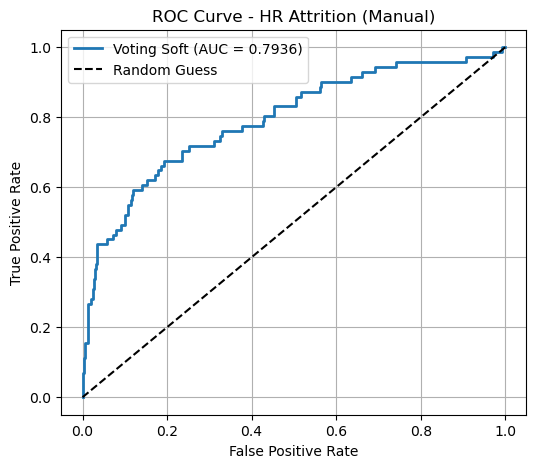


RUNNING BUILT-IN GRID SEARCH FOR HR ATTRITION

--- GridSearchCV for Decision Tree ---
Best params for Decision Tree: {'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'feature_selection__k': 5}
Best CV score: 0.7152

--- GridSearchCV for kNN ---
Best params for kNN: {'classifier__n_neighbors': 9, 'classifier__weights': 'distance', 'feature_selection__k': 40}
Best CV score: 0.7227

--- GridSearchCV for Logistic Regression ---
Best params for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'feature_selection__k': 40}
Best CV score: 0.8351
HR Attrition | Built-in | Decision Tree Accuracy: 0.8231
HR Attrition | Built-in | kNN Accuracy: 0.8503
HR Attrition | Built-in | Logistic Regression Accuracy: 0.8844
HR Attrition | Built-in | Majority Vote Accuracy: 0.8549
HR Attrition | Built-in Voting Accuracy: 0.8549
HR Attrition | Built-in Voting (Soft) ROC-AUC: 0.7936


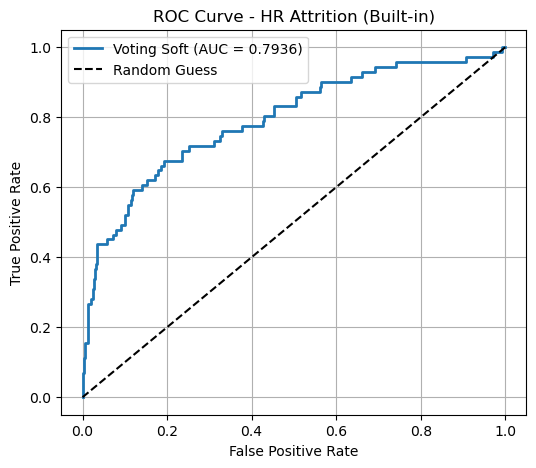


Completed processing for HR Attrition

ALL DATASETS PROCESSED!


In [56]:
# --- Run Pipeline for All Datasets ---
datasets = [
    (load_wine_quality, "Wine Quality"),
    (load_hr_attrition, "HR Attrition")
]

# Run for each dataset
for dataset_loader, dataset_name in datasets:
    try:
        run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)